In [1]:
import torch
import torch.nn as nn                         # to load all neural net functionality
import torch.nn.functional as F               # adds some efficiency
from torch.utils.data import DataLoader       # lets us load data in batches
from torchvision import datasets, transforms
import sklearn
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix  # for evaluating results
import matplotlib.pyplot as plt 
%matplotlib inline
import time
torch.manual_seed(101)                        # for consistent results

In [2]:
# set our datasets, one for training and one for test
Transform = transforms.ToTensor()
train = datasets.MNIST(root='../DATA', train=True, download=False, transform=Transform)
test = datasets.MNIST(root='../DATA', train=False, download=False, transform=Transform)

In [3]:
# batch the training data into batches of 100, shuffle after each epoch
# use smaller batches of 100 to update weights more often - this batch size is a hyperparameter
# that can be refined
train_loader = DataLoader(train, batch_size=100, shuffle=True)
# testing has no gradients or learning taking place so performance is less of a constraint and
# batch size can be as large as possible
test_loader = DataLoader(test, batch_size=500, shuffle=False)

In [4]:
# this perceptron will ingest our data to create a model
# it is based on the module class in pytorch
class MultilayerPerceptron(nn.Module): 
    def __init__(self, input_size=784, output_size=10, layers=[120,84]):
        super().__init__()
        # an __init__() call to the parent class must be made before assignment on the child
        # applies a linear transformation in this layer to the incoming data
        # https://www.youtube.com/watch?v=4PCktDZJH8E&t=12s
        self.d1 = nn.Linear(input_size,layers[0]) # hidden layer 1
        # pass the results to the next layer and apply another linear transformation
        self.d2 = nn.Linear(layers[0], layers[1]) # hidden layer 2
        # pass those results to one more linear layer
        self.d3 = nn.Linear(layers[1], output_size) # ouytput layer
        
    # per the documentation in pytorch, forward should be overridden by all subclasses.
    # defines the computation that is performed at every call
    def forward(self, X):
        # applies the rectified linear unit function element-wise.
        # from wikipedia: Rectified Linear Unit) activation function is an activation function defined
        # as the positive part of its argument: f(x)=x⁺=max(0,x) where x is the input to a neuron. 
        # This is also known as a ramp function and is analogous to half-wave rectification in electrical engineering
        X = F.relu(self.d1(X))
        X = F.relu(self.d2(X))
        X = self.d3(X)
        # https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html
        # https://deepai.org/machine-learning-glossary-and-terms/softmax-layer
        return F.log_softmax(X, dim=1)
    
model = MultilayerPerceptron()

In [5]:
# https://365datascience.com/tutorials/machine-learning-tutorials/cross-entropy-loss/
# measures your model’s performance by transforming its variables into real numbers, thus, evaluating the “loss” that’s associated with them. The higher the difference between the two, the higher the loss.
criterion = nn.CrossEntropyLoss()
# https://arxiv.org/abs/1412.6980
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [6]:
for images, labels in train_loader:
    print('Initial Batch shape:', images.size())
    break
print('Batch shape after flattening', images.view(100, -1).size())

Initial Batch shape: torch.Size([100, 1, 28, 28])
Batch shape after flattening torch.Size([100, 784])


In [7]:
epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train.view(100, -1)) # Here we flatten x_train
        loss = criterion(y_pred, y_train)
    
        # Calculate the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1] # the prediction that has the maximum probability
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
    
        # Update parameters
        optimizer.zero_grad() # reset the gradients after each training step
        loss.backward() # to trigger backprop
        optimizer.step() # perform parameter update
    
        # print interim results
        if b%600 == 0:
            print(f'epoch: {i:2} batch: {b:4} [{100*b:6}/60000] Train loss: {loss.item():10.8f} Train Accuracy: {trn_corr.item()*100/60000:.3f}%')
            
        # update training loss and accur
        train_losses.append(loss)
        train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad(): # don't calculate gradients during testing
        # https://www.quora.com/In-deep-learning-why-dont-we-use-the-whole-training-set-to-compute-the-gradient
        for b, (X_test, y_test) in enumerate(test_loader):
            
            # Apply the model
            y_val = model(X_test.view(500, -1)) # Here we flatten X_test
            
            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()

            # Update test loss & accuracy for the epoch
            loss = criterion(y_val, y_test)
            test_losses.append(loss)
            test_correct.append(tst_corr)

epoch:  0 batch:  600 [ 60000/60000] Train loss: 0.30252102 Train Accuracy: 92.708%
epoch:  1 batch:  600 [ 60000/60000] Train loss: 0.14284366 Train Accuracy: 96.062%
epoch:  2 batch:  600 [ 60000/60000] Train loss: 0.10179201 Train Accuracy: 96.763%
epoch:  3 batch:  600 [ 60000/60000] Train loss: 0.05633691 Train Accuracy: 97.270%
epoch:  4 batch:  600 [ 60000/60000] Train loss: 0.09295914 Train Accuracy: 97.445%
epoch:  5 batch:  600 [ 60000/60000] Train loss: 0.04685583 Train Accuracy: 97.518%
epoch:  6 batch:  600 [ 60000/60000] Train loss: 0.07953373 Train Accuracy: 97.723%
epoch:  7 batch:  600 [ 60000/60000] Train loss: 0.16864368 Train Accuracy: 97.910%
epoch:  8 batch:  600 [ 60000/60000] Train loss: 0.12595069 Train Accuracy: 98.080%
epoch:  9 batch:  600 [ 60000/60000] Train loss: 0.05573305 Train Accuracy: 98.172%


In [8]:
print(f'Test Accuracy: {test_correct[-1].item()*100/10000:.3f}%')

Test Accuracy: 96.980%


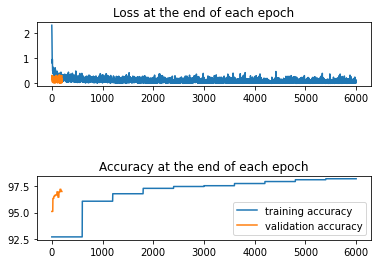

In [10]:
plt.subplot(3, 1, 1)
#print(train_losses) # tensor(0.0456, grad_fn=<NllLossBackward0>)
#print(test_losses) # tensor(0.2212)
# this is a part where knowing more math would come in handy.
# without spending more time to brush up on calculus and statistics, I can't understand
# the documentation behind these functions well enough to troubleshoot this error
# and am at the mercy of stack overflow; comparing the results of what I tried from there
# to the expected result from the blog - not quite what we were looking for
plt.plot([loss.detach() for loss in train_losses], label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')

plt.subplot(3, 1, 3)
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')

plt.legend()